In [1]:
import functools
from functools import partial
from collections import defaultdict
import copy

from pathos.multiprocessing import Pool

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output

import gym

FIG_SIZE = (16,5)
EPISODE_N = 200000
BLACKJACK_GEN = lambda: gym.make('Blackjack-v1', natural=True, sab=False)

>   ## Часть первая, с блекджеком и стратегиями
>    
>   1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
>    
>   2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
>    
>   3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [2]:
env = BLACKJACK_GEN()
while True:
    state = env.reset()
    if state[0] == 21:
        state, reward, done, info = env.step(0)
        print(state, reward, done, info)
        break

(21, 10, True) 1.5 True {}


In [3]:
def simple_policy(state, max_sum=19):
    action = 1 if state[0] < max_sum else 0
    return action

In [4]:
def play_episodes(n_episodes, env_gen, policy_fun):
    env = env_gen()
    
    sum_steps, sum_rewards = 0, 0
    for _ in range(n_episodes):
        state = env.reset()
        
        while state[0] < 12:
            state, reward, done, info = env.step(1)

        for step in range(1,100):
            if state[0] == 21:
                action = 0
            else:
                action = policy_fun(state)

            state, reward, done, info = env.step(action)
            if done:
                sum_steps += step
                sum_rewards += reward
                break
    env.close()
    return sum_rewards / n_episodes, sum_steps / n_episodes

In [5]:
def pplay_episodes(n_episodes, env_gen, policy_fun, np=1000):
    with Pool() as P:
        rewards_steps = P.map(partial(play_episodes, env_gen=env_gen, policy_fun=policy_fun),
                              [n_episodes // np for _ in range(np)])
    mean_rewards, mean_steps = [sum(r) / len(r) for r in zip(*rewards_steps)]
    return mean_rewards, mean_steps

In [6]:
%%time
mean_rewards, mean_steps = pplay_episodes(EPISODE_N,
                                          BLACKJACK_GEN, 
                                          partial(simple_policy, max_sum=19))
print(f"Средняя награда: {mean_rewards}\nСреднее число шагов: {mean_steps}")  

Средняя награда: -0.17979500000000018
Среднее число шагов: 1.5049349999999977
CPU times: user 169 ms, sys: 37 ms, total: 206 ms
Wall time: 2.57 s


In [7]:
%%time
[(max_sum,) + pplay_episodes(EPISODE_N,
                             BLACKJACK_GEN, 
                             partial(simple_policy, max_sum=max_sum))
 for max_sum in range(12,21)]

CPU times: user 1.27 s, sys: 306 ms, total: 1.57 s
Wall time: 22.3 s


[(12, -0.08751250000000013, 1.0),
 (13, -0.07452500000000001, 1.0823700000000105),
 (14, -0.05955749999999996, 1.1639399999999953),
 (15, -0.053810000000000004, 1.2405050000000024),
 (16, -0.05271250000000001, 1.3166600000000004),
 (17, -0.05704000000000002, 1.3864700000000019),
 (18, -0.09064499999999992, 1.4491149999999997),
 (19, -0.18338749999999962, 1.5030499999999996),
 (20, -0.3334875000000003, 1.5573750000000002)]

Итак, если смотреть только на сумму своих карт, то лучше всего заканчивать игру на 14-17 очках.

Попробуем улучшить статерию, учитывая все доступные компоненты состояния.

In [8]:
class Reward:
    # statistic of rewards on some action
    def __init__(self, s=0, c=0, m=0):
        self.sum = s
        self.cnt = c
        self.mean = m
        
    def __repr__(self):
        return f"Return sum={self.sum}, cnt={self.cnt}, mean={self.mean}"
    
    def add(self, r, lr=-1):
        self.cnt += 1
        self.sum += r
        if lr > 0:
            self.mean += lr * (r - self.mean)
        else:
            self.mean = self.sum / self.cnt
     
    @staticmethod
    def mean(rewards):
        if not rewards:
            return Reward()
        r_sum = sum([r.sum for r in rewards]) / len(rewards)
        r_cnt = sum([r.cnt for r in rewards]) / len(rewards)
        r_mean = sum([r.mean * r.cnt for r in rewards]) / sum([r.cnt for r in rewards]) if r_cnt else 0
        return Reward(r_sum, r_cnt, r_mean)
    
    @staticmethod
    def max(rewards):
        return max([r.mean for r in rewards])
    
    @staticmethod
    def greedy(rewards):
        return np.argmax([r.mean for r in rewards])
    
    @staticmethod
    def eps_greedy(rewards, eps=0.2):
        return np.random.randint(len(rewards)) if np.random.rand() < eps else np.argmax([r.mean for r in rewards])

    @staticmethod
    def ucb1(rewards, C=np.sqrt(2)):
        n = sum([r.cnt for r in rewards]) or 1
        priorities = [
            r.mean + (C * np.sqrt(np.log(n) / r.cnt) if r.cnt != 0 else 10)
            for r in rewards
        ]
        return np.argmax(priorities)

In [9]:
def episode_MC_control(Q, env, state, explore_action_fun, max_steps=100):
    episode_history = []
    for step in range(max_steps):
        if state[0] == 21:
            action = 0
        else:
            greedy_action = Reward.greedy(Q[state])
            action = explore_action_fun(Q[state])
            episode_history.append((state, action, greedy_action))

        state, reward, done, info = env.step(action)
        if done:
            for state, action, greedy_action in episode_history[::-1]:
                Q[state][action].add(reward)
                if action != greedy_action: # off-policy
                    break
            break
    return reward

In [10]:
def episode_Q_learning(Q, env, state, explore_action_fun, max_steps=100, lr=1e-4):
    for step in range(max_steps):
        if state[0] == 21:
            state1, reward, done, info = env.step(0)
        else:
            action = explore_action_fun(Q[state])
            state_next, reward, done, info = env.step(action)
            if done:
                Q[state][action].add(reward, lr=lr)
            else:
                Q[state][action].add(reward + Reward.max(Q[state_next]), lr=lr) # reward=0
            state = state_next
        
        if done:
            break
    return reward

In [11]:
def train(Q, env_gen, n_episodes, episode_train_fun):
    # episode_train_fun = episode_Q_learning or episode_MC_control
    env = env_gen()
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()

        while state[0] < 12:
            state, _, _, _ = env.step(1)

        episode_train_fun(Q, env, state)
    env.close()        
    return Q

Вариант обучения с распараллеливанием и дальнейшим усреднением

In [12]:
def ptrain(Q, env_gen, n_episodes, episode_train_fun, np=10):
    with Pool() as P:
        Q_list = P.map(partial(train, 
                              env_gen=env_gen, 
                              n_episodes=n_episodes, 
                              episode_train_fun=episode_train_fun),
                      [copy.deepcopy(Q) for _ in range(np)])
    states = Q.keys()
    for q in Q_list:
        states |= q.keys()
    for state in states:
        rewards_list = [q[state] for q in Q_list if state in q]
        actions_list = zip(*rewards_list)
        Q[state] = tuple(Reward.mean(r_list) for r_list in actions_list)

    return Q

In [13]:
class Game:
    def __init__(self, env_gen, train_fun=ptrain):
        self._train_fun = train_fun
        self._env_gen = env_gen
        nA = env_gen().action_space.n
        self.Q = defaultdict(lambda : tuple(Reward() for _ in range(nA)))
        
    def policy_from_Q(self):
        pi = defaultdict(lambda : 0)
        for state in self.Q:
            pi[state] = Reward.greedy(self.Q[state])
        return pi
       
    def train_show(self, n_episodes, episode_train_fun, episodes_step=10000):
        plot_data = {'x':[], 'y':[]}
        for i_step in range(1, n_episodes//episodes_step + 1):
            
            self._train_fun(self.Q, self._env_gen, episodes_step, episode_train_fun)

            pi = self.policy_from_Q()
            mean_rewards, mean_steps = pplay_episodes(EPISODE_N, self._env_gen, lambda s : pi[s])
            
            plot_data['x'].append(i_step * episodes_step)
            plot_data['y'].append(mean_rewards)
            clear_output(True)
            plt.figure(figsize=FIG_SIZE)
            plt.plot(plot_data['x'], plot_data['y'], '-r.')
            plt.grid()
            plt.show()      
    

Q-learing c постоянным шагом обучения и распараллеливанием обучения

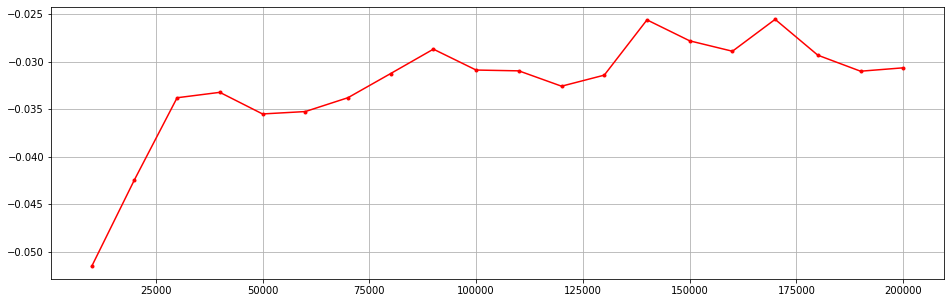

CPU times: user 14.1 s, sys: 1.88 s, total: 16 s
Wall time: 1min 26s


In [14]:
%%time
g = Game(BLACKJACK_GEN, train_fun=partial(ptrain, np=10))
Game.train_show(g, n_episodes=200000, 
                   episode_train_fun=partial(episode_Q_learning, 
                                             lr=0.01,
                                             explore_action_fun=partial(Reward.eps_greedy, 
                                                                        eps=0.2)
                                            )
                  )

Q-learing c обычным усреднением, последовательное в один поток

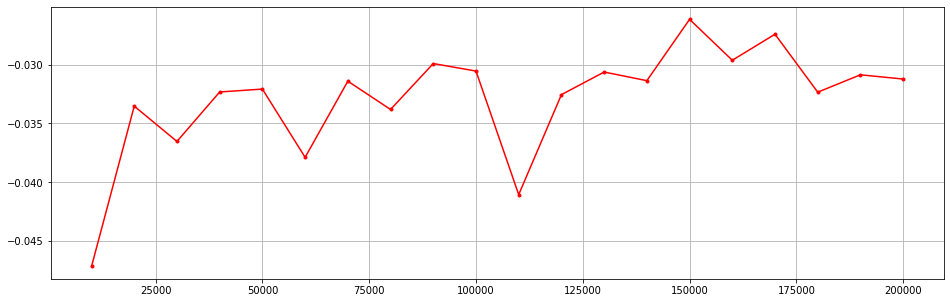

CPU times: user 29 s, sys: 2.72 s, total: 31.8 s
Wall time: 1min 11s


In [15]:
%%time
g = Game(BLACKJACK_GEN, train_fun=train)
g.train_show(n_episodes=200000, 
               episode_train_fun=partial(episode_Q_learning, 
                                         lr=-1,
                                         explore_action_fun=partial(Reward.eps_greedy, 
                                                                    eps=0.2)
                                        )
              )

Monte-Carlo control c eps-greedy exploration

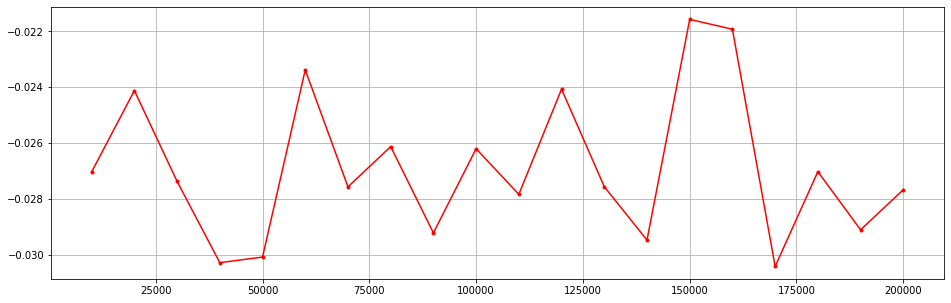

CPU times: user 13.6 s, sys: 1.94 s, total: 15.5 s
Wall time: 1min 32s


In [16]:
%%time
g = Game(BLACKJACK_GEN, train_fun=partial(ptrain, np=10))
g.train_show(n_episodes=200000, 
           episode_train_fun=partial(episode_MC_control, 
                                     explore_action_fun=partial(Reward.eps_greedy, 
                                                                eps=0.2)
                                    )
          )

Monte-Carlo control c UCB1 exploration

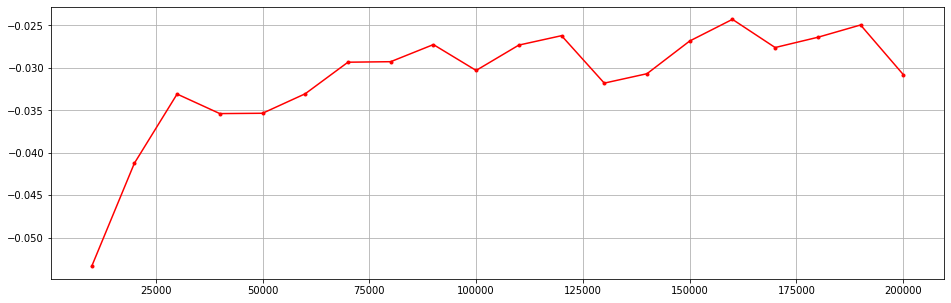

CPU times: user 32.2 s, sys: 2.58 s, total: 34.8 s
Wall time: 1min 16s


In [17]:
%%time
g = Game(BLACKJACK_GEN, train_fun=train)
g.train_show(n_episodes=200000, 
           episode_train_fun=partial(episode_MC_control, 
                                     explore_action_fun=partial(Reward.ucb1, 
                                                                C=np.sqrt(2))
                                    )
          )

In [18]:
sorted([(key, 
         0 if value[0].mean > value[1].mean else 1, 
         value[0].mean, value[0].cnt,
         value[1].mean, value[1].cnt,) 
        for key, value in g.Q.items()], 
       key=lambda x: x[0])

[((12, 1, False), 1, -0.7081081081081081, 185, -0.5230446927374302, 1432),
 ((12, 1, True), 1, -0.6923076923076923, 13, -0.20967741935483872, 62),
 ((12, 2, False), 1, -0.582089552238806, 67, -0.19892793329362715, 1679),
 ((12, 2, True), 1, -1.0, 5, -0.03076923076923077, 65),
 ((12, 3, False), 0, -0.2162773172569706, 1327, -0.31564245810055863, 358),
 ((12, 3, True), 0, -0.07142857142857142, 56, -0.19444444444444445, 36),
 ((12, 4, False), 1, -0.23798882681564246, 895, -0.2335680751173709, 852),
 ((12, 4, True), 1, -0.6666666666666666, 6, 0.24324324324324326, 74),
 ((12, 5, False), 0, -0.21729490022172948, 902, -0.2258852258852259, 819),
 ((12, 5, True), 1, -0.25, 8, 0.34615384615384615, 52),
 ((12, 6, False), 0, -0.1280701754385965, 1140, -0.17870036101083034, 554),
 ((12, 6, True), 0, -0.07462686567164178, 67, -0.08333333333333333, 24),
 ((12, 7, False), 1, -0.8461538461538461, 26, -0.17276544691061788, 1667),
 ((12, 7, True), 1, -0.7777777777777778, 9, -0.046875, 64),
 ((12, 8, Fals

In [19]:
len(g.Q)

180

Итак, обучением Q-функции на 180 состояний удалось немного улучшить средний выигрыш с (-0,05) до (-0,03).
MC-control методы оказались немного лучше Q-learning.

>## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
>
>   • double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
>    
>   4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
>   5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [20]:
class DoubleBlackjack(gym.Env):
    def __init__(self, env):
        self._env = env
        
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = self._env.observation_space
        
        
    def step(self, action):   
        if action == 2:
            state, reward, done, info = self._env.step(1)
            if not done:
                state, reward, done, info = self._env.step(0)
            reward *= 2
        else:
            state, reward, done, info = self._env.step(action)
            
        return state, reward, done, info

    
    def reset(self):     
        return self._env.reset()
    
    def close(self):
        self._env.close()

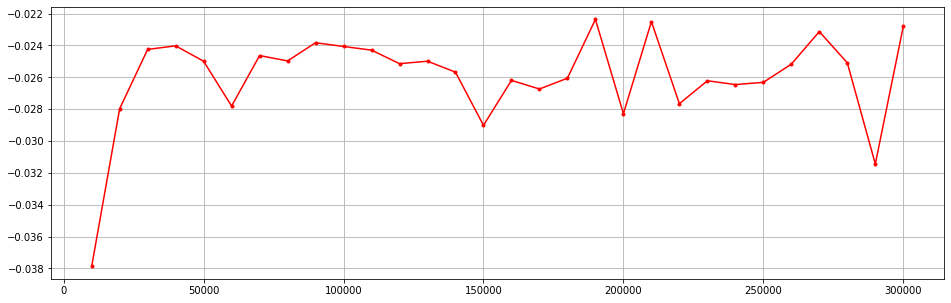

CPU times: user 22.3 s, sys: 2.92 s, total: 25.2 s
Wall time: 2min 24s


In [21]:
%%time
g = Game(lambda: DoubleBlackjack(BLACKJACK_GEN()), train_fun=partial(ptrain, np=10))
g.train_show(n_episodes=300000, 
           episode_train_fun=partial(episode_MC_control, 
                                     explore_action_fun=partial(Reward.ucb1, 
                                                                C=np.sqrt(2))
                                    )
          )

In [22]:
g.policy_from_Q()

defaultdict(<function __main__.Game.policy_from_Q.<locals>.<lambda>()>,
            {(15, 5, False): 0,
             (18, 10, False): 0,
             (12, 10, False): 1,
             (16, 5, False): 0,
             (17, 10, True): 1,
             (20, 6, False): 0,
             (12, 9, True): 1,
             (13, 4, True): 1,
             (14, 3, False): 0,
             (18, 7, False): 0,
             (16, 6, True): 1,
             (19, 2, False): 0,
             (16, 7, False): 1,
             (20, 7, True): 0,
             (15, 6, True): 2,
             (20, 1, False): 0,
             (14, 5, False): 0,
             (15, 10, True): 1,
             (17, 1, False): 0,
             (20, 9, True): 0,
             (13, 5, True): 2,
             (19, 8, False): 0,
             (19, 5, True): 0,
             (14, 4, True): 1,
             (13, 10, False): 1,
             (17, 3, False): 0,
             (18, 1, True): 1,
             (12, 2, False): 1,
             (18, 2, False): 0,
       

Возможность удвоения ставки почти не повлияла на средний выигрыш.

>## Часть третья, в главной роли — Дастин Хоффман
>А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит.
>
> 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
>
> 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Новое окружение реализовано в файле my_blackjack.py. Подсчет осуществляется в виде среднего значения карт на начало раздачи (умноженного на 3 и округленного до целого), которое добавляется четвертым компонентом в состояние.

In [23]:
from my_blackjack import DoubleBlackjackWithCntEnv

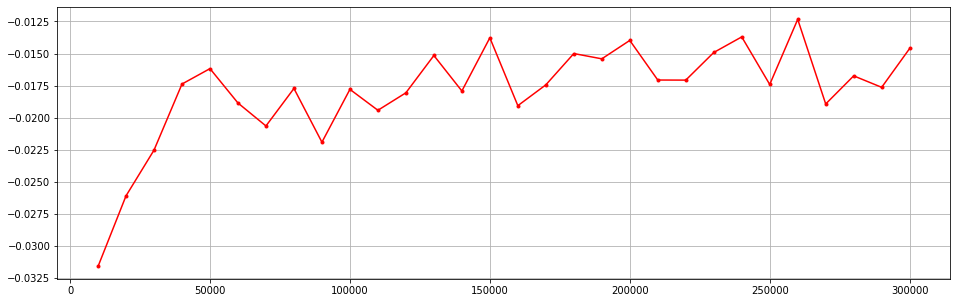

CPU times: user 2min 10s, sys: 3.36 s, total: 2min 13s
Wall time: 3min 14s


In [24]:
%%time
g = Game(lambda: DoubleBlackjackWithCntEnv(), train_fun=partial(ptrain, np=10))
g.train_show(n_episodes=300000, 
           episode_train_fun=partial(episode_MC_control, 
                                     explore_action_fun=partial(Reward.ucb1, 
                                                                C=np.sqrt(2))
                                    )
          )

Окружение с учетом уменьшающейся колоды и обучение стратерии с подсчетом карт дали существенный прирост среднего выигрыша, однако казино обыграть все равно не удалось.